In [20]:
import os

outfile_root = '/cfarhomes/mgwillia/unsupervised-analysis/outfiles/'

fgvc_datasets = ['aircraft', 'cars', 'cub', 'dogs', 'flowers', 'nabirds']
results = {}
for dataset_name in fgvc_datasets:
    results[dataset_name] = {}
results['imagenet'] = {}

file_names = ['knn_aircraft.out.865', 'knn_cars.out.893', 'knn_cub.out.868', 'knn_dogs.out.895', 'knn_flowers.out.870', 'knn_inet.out.871', 'knn_nabirds.out.872']
for file_name in file_names:
    dataset_name = file_name.split('_')[1].split('.')[0].replace('inet', 'imagenet')
    print(dataset_name)
    with open(os.path.join(outfile_root, file_name), 'r') as read_file:
        lines = read_file.readlines()
        if dataset_name == 'imagenet':
            #for line in lines:
                #if 'backbone' in line:
                #    method_name = line.split(' ')[7][:-1]
                #    if method_name not in results[dataset_name]:
                #        results[dataset_name][method_name] = {}
                #        results[dataset_name][method_name]['top1'] = []
                #        results[dataset_name][method_name]['top5'] = []
                #if 'Top1' in line:
                #    top1 = float(line.split(' ')[4][:-1])
                #    top5 = float(line.strip().split(' ')[6])
                #    results[dataset_name][method_name]['top1'].append(top1)
                #    results[dataset_name][method_name]['top5'].append(top5)
            for line in lines[1:]:
                stripped_line = line.strip()
                method_name = stripped_line.split(' ')[1][:-1]
                if method_name not in results[dataset_name]:
                    results[dataset_name][method_name] = {}
                    results[dataset_name][method_name]['top1'] = []
                    results[dataset_name][method_name]['top5'] = []
                top1 = float(stripped_line.split(' ')[-3][:-1])
                top5 = float(stripped_line.strip().split(' ')[-1])
                results[dataset_name][method_name]['top1'].append(top1)
                results[dataset_name][method_name]['top5'].append(top5)
        else:
            for line in lines[1:]:
                stripped_line = line.strip()
                method_name = stripped_line.split(' ')[1][:-1]
                if method_name not in results[dataset_name]:
                        results[dataset_name][method_name] = {}
                num_neighbors = int(stripped_line.split(' ')[10][:-1])
                if num_neighbors not in results[dataset_name][method_name]:
                    results[dataset_name][method_name][num_neighbors] = {}
                    results[dataset_name][method_name][num_neighbors]['top1'] = []
                    results[dataset_name][method_name][num_neighbors]['top5'] = []
                top1 = float(stripped_line.split(' ')[-3][:-1])
                top5 = float(stripped_line.strip().split(' ')[-1])
                results[dataset_name][method_name][num_neighbors]['top1'].append(top1)
                results[dataset_name][method_name][num_neighbors]['top5'].append(top5)

aircraft
cars
cub
dogs
flowers
imagenet
nabirds


In [21]:
import numpy as np

for dataset_name in results.keys():
    for method_name in results[dataset_name].keys():
        if dataset_name == 'imagenet':
            results[dataset_name][method_name]['top1_mean'] = np.mean(results[dataset_name][method_name]['top1'])
            results[dataset_name][method_name]['top1_std'] = np.std(results[dataset_name][method_name]['top1'])   
        else:
            for num_neighbors in results[dataset_name][method_name].keys():
                results[dataset_name][method_name][num_neighbors]['top1_mean'] = np.mean(results[dataset_name][method_name][num_neighbors]['top1'])
                results[dataset_name][method_name][num_neighbors]['top1_std'] = np.std(results[dataset_name][method_name][num_neighbors]['top1'])
                    

In [22]:
print(results['imagenet'].keys())

dict_keys(['btwins_r50_1000', 'dcv2_r50_800', 'moco_r50_800', 'simclr_r50_800', 'simsiam_r50_100', 'supervised_r50', 'swav_r50_800'])


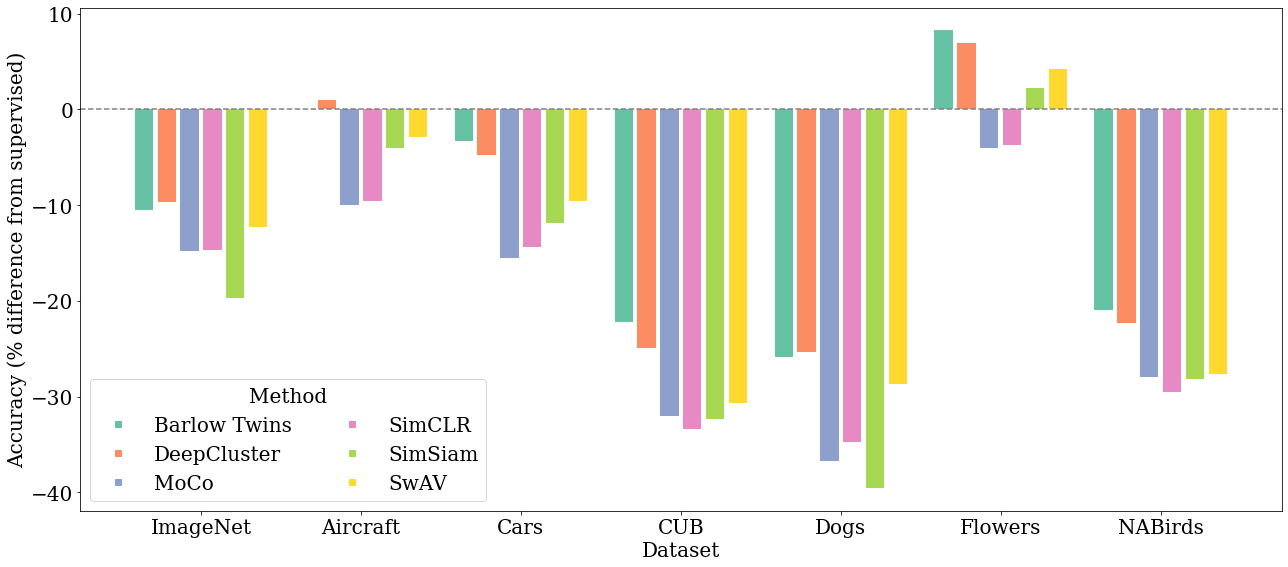

In [30]:
### MAKE BAR PLOT ###
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,8)
cmap = plt.get_cmap('Set2')
plt.rcParams["font.family"] = "serif"
colormap = np.array(list(cmap.colors))

method_table_results = {}
for dataset_name, dataset_results in results.items():
    for method_name, method_results in dataset_results.items():
        if method_name.split("_")[0] not in method_table_results:
            method_table_results[method_name.split("_")[0]] = {}
        if dataset_name == 'imagenet':
            method_table_results[method_name.split("_")[0]][dataset_name] = method_results
        else:
            max_top1 = 0.0
            best_num_neighbors = 0
            for num_neighbors, neighbors_results in method_results.items():
                top1 = neighbors_results['top1_mean']
                if top1 > max_top1:
                    max_top1 = top1
                    best_num_neighbors = num_neighbors
            method_table_results[method_name.split("_")[0]][dataset_name] = method_results[best_num_neighbors]

datasets = ['ImageNet', 'Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds']
method_names = ['btwins', 'dcv2', 'moco', 'simclr', 'simsiam', 'swav']
method_print_name = {
    'btwins': 'BTwins',
    'dcv2': 'DCv2',
    'moco': 'MoCo',
    'simclr': 'SimCLR',
    'simsiam': 'SimSiam',
    'supervised': 'Supervised',
    'swav': 'SwAV',
}

fig, ax = plt.subplots(1, 1)
layer_name = 'res5'
dataset_ids = []
method_ids = []
accuracies = []
for i, dataset_name in enumerate(datasets):
    for j, method_name in enumerate(method_names):
        final_accuracy = method_table_results[method_name][dataset_name.lower()]['top1_mean']
        dataset_ids.append(i * (len(method_names) + 1) + j + 1)
        method_ids.append(j)
        accuracies.append(final_accuracy - method_table_results['supervised'][dataset_name.lower()]['top1_mean'])
ax.bar(dataset_ids, accuracies, color=colormap[method_ids])
#ax.legend([], [], title=f'Layer: {layer_name}', title_fontsize=16, loc='lower right', frameon=False)
ax.set_xticks(0.5 + np.array(list(range(3, len(datasets) * 7 + 3, 7))))
ax.set_xticklabels(datasets, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.axhline(y=0.0, color='gray', linestyle='--')
    
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in range(7)]
ax.legend(handles,
          ['Barlow Twins', 'DeepCluster', 'MoCo', 'SimCLR', 'SimSiam', 'SwAV'],
          title='Method',
          title_fontsize=20,
          scatterpoints=1,
          ncol=2,
          fontsize=20)


ax.set_xlabel('Dataset', fontsize=20)
ax.set_ylabel('Accuracy (% difference from supervised)', fontsize=20)

fig.tight_layout()
plt.savefig(f'knn_results.pdf', bbox_inches = 'tight',
    pad_inches = 0.1)

In [11]:
### MAKE KNN TABLE ###

datasets = ['ImageNet', 'Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds']
method_print_name = {
    'btwins': 'BTwins',
    'dcv2': 'DCv2',
    'moco': 'MoCo',
    'simclr': 'SimCLR',
    'simsiam': 'SimSiam',
    'supervised': 'Supervised',
    'swav': 'SwAV',
}

print('\\begin{tabular}{l l l l l l l l}')
print('\\multirow{2}{*}{Method} & \\multicolumn{7}{c}{Dataset} \\\\ \\cmidrule{2-8}')
print('{} & \\multicolumn{1}{c}{' + '} & \\multicolumn{1}{c}{'.join(datasets) + '} \\\\')
print('\\midrule')
for method_name, method_results in method_table_results.items():
    accs = []
    for dataset_name in datasets:
        accs.append(f'{method_results[dataset_name.lower()]["top1_mean"]:.2f}')
    print(f'\t{method_print_name[method_name.split("_")[0]]} & {" & ".join(accs)} \\\\')
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{l l l l l l l l}
\multirow{2}{*}{Method} & \multicolumn{7}{c}{Dataset} \\ \cmidrule{2-8}
{} & \multicolumn{1}{c}{ImageNet} & \multicolumn{1}{c}{Aircraft} & \multicolumn{1}{c}{Cars} & \multicolumn{1}{c}{CUB} & \multicolumn{1}{c}{Dogs} & \multicolumn{1}{c}{Flowers} & \multicolumn{1}{c}{NABirds} \\
\midrule
	BTwins & 62.91 & 31.47 & 26.97 & 34.38 & 62.58 & 86.37 & 22.38 \\
	DCv2 & 63.75 & 32.43 & 25.49 & 31.69 & 63.09 & 85.05 & 21.08 \\
	MoCo & 58.55 & 21.48 & 14.74 & 24.51 & 51.64 & 74.09 & 15.45 \\
	SimCLR & 58.67 & 21.87 & 15.84 & 23.20 & 53.66 & 74.40 & 13.83 \\
	SimSiam & 53.67 & 27.42 & 18.39 & 24.23 & 48.88 & 80.37 & 15.24 \\
	Supervised & 73.39 & 31.41 & 30.24 & 56.58 & 88.41 & 78.11 & 43.36 \\
	SwAV & 61.10 & 28.53 & 20.71 & 25.87 & 59.77 & 82.35 & 15.71 \\
\bottomrule
\end{tabular}


In [17]:
### MAKE KNN SMALL TABLE ###

datasets = ['ImageNet', 'Aircraft', 'Flowers', 'NABirds']
method_print_name = {
    'btwins': 'BTwins',
    'dcv2': 'DCv2',
    'moco': 'MoCo',
    'simclr': 'SimCLR',
    'simsiam': 'SimSiam',
    'supervised': 'Supervised',
    'swav': 'SwAV',
}

print('\\begin{tabular}{@{}l c c c c@{}}')
print('\\multirow{2}{*}{Method} & \\multicolumn{4}{c@{}}{Dataset} \\\\ \\cmidrule{2-5}')
print('{} & \\multicolumn{1}{c@{}}{' + '} & \\multicolumn{1}{c@{}}{'.join(datasets) + '} \\\\')
print('\\midrule')
for method_name, method_results in method_table_results.items():
    accs = []
    for dataset_name in datasets:
        accs.append(f'{method_results[dataset_name.lower()]["top1_mean"]:.2f}')
    print(f'\t{method_print_name[method_name.split("_")[0]]} & {" & ".join(accs)} \\\\')
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{@{}l c c c c@{}}
\multirow{2}{*}{Method} & \multicolumn{4}{c@{}}{Dataset} \\ \cmidrule{2-5}
{} & \multicolumn{1}{c@{}}{ImageNet} & \multicolumn{1}{c@{}}{Aircraft} & \multicolumn{1}{c@{}}{Flowers} & \multicolumn{1}{c@{}}{NABirds} \\
\midrule
	BTwins & 62.91 & 31.47 & 86.37 & 22.38 \\
	DCv2 & 63.75 & 32.43 & 85.05 & 21.08 \\
	MoCo & 58.55 & 21.48 & 74.09 & 15.45 \\
	SimCLR & 58.67 & 21.87 & 74.40 & 13.83 \\
	SimSiam & 53.67 & 27.42 & 80.37 & 15.24 \\
	Supervised & 73.39 & 31.41 & 78.11 & 43.36 \\
	SwAV & 61.10 & 28.53 & 82.35 & 15.71 \\
\bottomrule
\end{tabular}
